In [95]:
import os
from typing import Callable, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import poisson, norm
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from deep_uncertainty.evaluation.calibration import compute_average_calibration_score, plot_regression_calibration_curve
from deep_uncertainty.evaluation.metrics import get_mse, get_calibration, get_med_se
from deep_uncertainty.evaluation.plots import get_sigma_plot_from_test
from deep_uncertainty.evaluation.evals import evaluate_model_criterion
from deep_uncertainty.models.random_variables import DoublePoisson
from deep_uncertainty.models.regressors import DoublePoissonNN, RegressionNN
from deep_uncertainty.utils.generic_utils import get_yaml
from deep_uncertainty.utils.model_utils import train_regression_nn

## Setup

In [12]:
config = get_yaml("../toy/toy_exp_train_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
X_train = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_x_train.txt"))
X_val = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_x_val.txt"))
X_test = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_x_test.txt"))
y_train = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_y_train.txt"))
y_val = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_y_val.txt"))
y_test = np.loadtxt(os.path.join("..", config['dataset']["dir"].replace(".", ".."), config['dataset']["name"] + "_y_test.txt"))
train_dataset = TensorDataset(
    torch.Tensor(X_train.reshape(-1, 1)),
    torch.Tensor(y_train.reshape(-1, 1))
)
val_dataset = TensorDataset(
    torch.Tensor(X_val.reshape(-1, 1)),
    torch.Tensor(y_val.reshape(-1, 1))
)
test_dataset = TensorDataset(
    torch.Tensor(X_test.reshape(-1, 1)),
    torch.Tensor(y_test.reshape(-1, 1))
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
num_trials = 5
num_epochs = config['optim']['epochs']

In [30]:
def train_model(model_type: nn.Module, criterion: Callable) -> Tuple[nn.Module, List[float], List[float]]:
    model = model_type()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    progress_bar = tqdm(range(num_epochs), desc="Training", unit="epoch")
    trn_losses = []
    val_losses = []

    for epoch in progress_bar:

        train_loss = train_regression_nn(
            train_loader=train_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        val_loss = evaluate_model_criterion(
            val_loader=val_loader,
            model=model,
            criterion=criterion,
            device=device,
        )

        progress_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})
        trn_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return model, trn_losses, val_losses

In [35]:
def evaluate_model(model: nn.Module, outputs_to_rv: Callable, rv_to_mu: Callable, plot: bool = False) -> Dict[str, float]:
    with torch.inference_mode():
        outputs = []
        y_vals = []
        model.eval()
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs.append(model(X))
            y_vals.extend(y)

    outputs = torch.cat(outputs)
    posterior = outputs_to_rv(outputs)
    y_vals = np.array(y_vals).flatten()

    # Evaluation metrics / plots.

    mu_vals = rv_to_mu(posterior)
    test_mse = get_mse(y_vals, mu_vals)
    test_med_se = get_med_se(y_vals, mu_vals)
    
    lower = posterior.ppf(0.025)
    upper = posterior.ppf(0.975)
    test_calib = get_calibration(y_vals, upper, lower)
    mean_calib = compute_average_calibration_score(y_vals, posterior)
    
    if plot:
        get_sigma_plot_from_test(X_test, y_test, mu_vals, upper=upper, lower=lower)
        plot_regression_calibration_curve(
            y_true=y_vals,
            posterior_predictive_distribution=posterior,
            num_bins=15,
        )
    
    return {"mse": test_mse, "med_se": test_med_se, "calibration@0.95": test_calib, "mean_calibration": mean_calib}

## Gaussian Regression

In [96]:
class GaussianDNN(nn.Module):
    def __init__(self):
        super(GaussianDNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        return self.layers(x)   # (n, 2)

In [97]:
def gaussian_nll(outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    mu, logvar = torch.split(outputs, [1, 1], dim=-1)
    loss = 0.5 * (torch.exp(-logvar) * (targets - mu) ** 2 + logvar).mean() 
    return loss

In [93]:
def gaussian_outputs_to_rv(outputs: torch.Tensor) -> norm:
    mu, logvar = torch.split(outputs, [1, 1], dim=-1)
    std = torch.sqrt(torch.exp(logvar))
    return norm(loc=mu.flatten().numpy(), scale=std.flatten().numpy())

def gaussian_rv_to_mu(rv: norm) -> np.ndarray:
    return rv.kwds['loc']

Training: 100%|██████████| 500/500 [00:12<00:00, 39.98epoch/s, Train Loss=1.3513, Val Loss=1.2302]


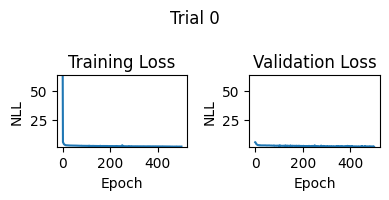

Training: 100%|██████████| 500/500 [00:13<00:00, 38.05epoch/s, Train Loss=1.2544, Val Loss=1.2476]


In [98]:
gaussian_models = []
trial_to_plot = np.random.choice(num_trials)

for trial in range(num_trials):

    model, trn_losses, val_losses = train_model(lambda: GaussianDNN(), gaussian_nll)
    gaussian_models.append(model)

    if trial == trial_to_plot:
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))
        fig.suptitle(f"Trial {trial}")

        axs[0].plot(trn_losses)
        axs[0].set_title("Training Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("NLL")

        axs[1].plot(val_losses)
        axs[1].set_title("Validation Loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("NLL")

        y_low = min(np.min(trn_losses), np.min(val_losses))
        y_high = max(np.max(trn_losses), np.max(val_losses))
        [ax.set_ylim(y_low, y_high) for ax in axs]

        plt.tight_layout()
        plt.show()

Evaluating Gaussian models...:   0%|          | 0/5 [00:00<?, ?it/s]

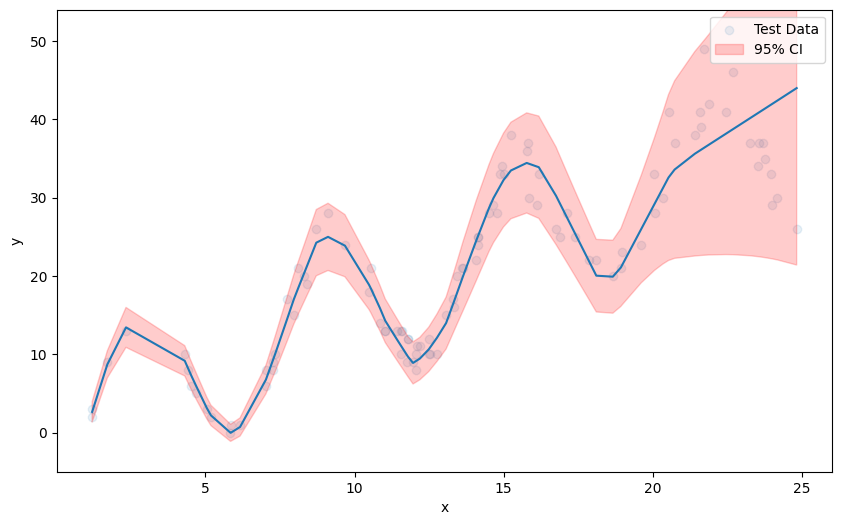

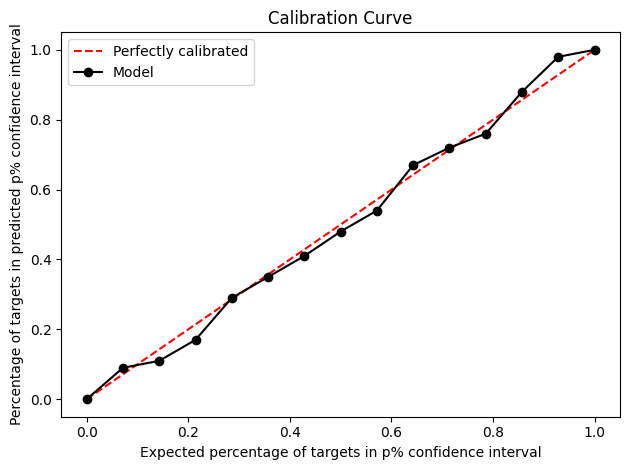

Evaluating Gaussian models...: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


In [100]:
gaussian_mse = []
gaussian_med_se = []
gaussian_calibration_at_95 = []
gaussian_mean_calibration = []

eval_loop = tqdm(gaussian_models, desc="Evaluating Gaussian models...")

for trial, model in enumerate(eval_loop):
    plot = trial == trial_to_plot
    metrics = evaluate_model(model, gaussian_outputs_to_rv, gaussian_rv_to_mu, plot)
    gaussian_mse.append(metrics["mse"])
    gaussian_med_se.append(metrics["med_se"])
    gaussian_calibration_at_95.append(metrics["calibration@0.95"])
    gaussian_mean_calibration.append(metrics["mean_calibration"])

## Poisson Regression

In [94]:
def poisson_outputs_to_rv(outputs: torch.Tensor) -> poisson:
    return poisson(mu=outputs.flatten().numpy())

def poisson_rv_to_mu(rv: poisson) -> np.ndarray:
    return rv.kwds['mu']

Training: 100%|██████████| 500/500 [00:11<00:00, 41.89epoch/s, Train Loss=-45.5133, Val Loss=1599463138338537472.0000]    


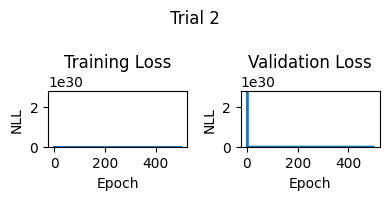

Training: 100%|██████████| 500/500 [00:11<00:00, 42.88epoch/s, Train Loss=-45.4982, Val Loss=81944270653494394880.0000]    


In [48]:
criterion = nn.PoissonNLLLoss()

poisson_models = []
trial_to_plot = np.random.choice(num_trials)

for trial in range(num_trials):

    model, trn_losses, val_losses = train_model(lambda: RegressionNN(True), criterion)
    poisson_models.append(model)

    if trial == trial_to_plot:
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))
        fig.suptitle(f"Trial {trial}")

        axs[0].plot(trn_losses)
        axs[0].set_title("Training Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("NLL")

        axs[1].plot(val_losses)
        axs[1].set_title("Validation Loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("NLL")

        y_low = min(np.min(trn_losses), np.min(val_losses))
        y_high = max(np.max(trn_losses), np.max(val_losses))
        [ax.set_ylim(y_low, y_high) for ax in axs]

        plt.tight_layout()
        plt.show()

Evaluating Poisson models...:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

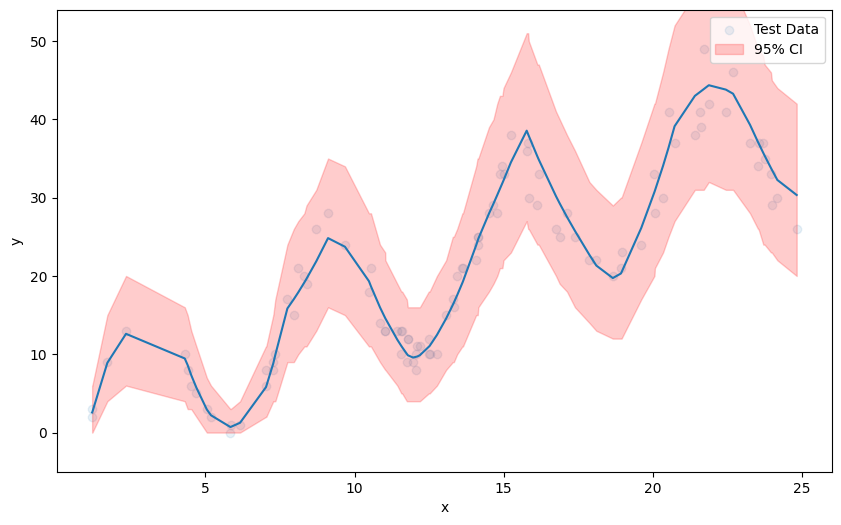

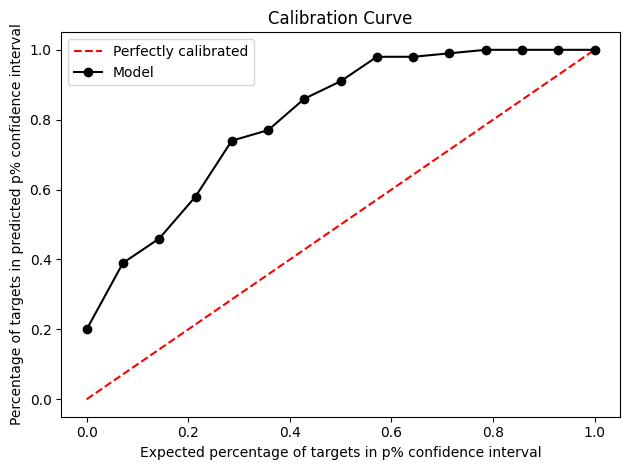

Evaluating Poisson models...: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


In [75]:
poisson_mse = []
poisson_med_se = []
poisson_calibration_at_95 = []
poisson_mean_calibration = []

eval_loop = tqdm(poisson_models, desc="Evaluating Poisson models...")

for trial, model in enumerate(eval_loop):
    plot = trial == trial_to_plot
    metrics = evaluate_model(model, poisson_outputs_to_rv, poisson_rv_to_mu, plot)
    poisson_mse.append(metrics["mse"])
    poisson_med_se.append(metrics["med_se"])
    poisson_calibration_at_95.append(metrics["calibration@0.95"])
    poisson_mean_calibration.append(metrics["mean_calibration"])

## Double Poisson Regression

In [38]:
def double_poisson_nll(output: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """Compute the mean double poisson negative log likelihood over the given targets.

    Args:
        output (torch.Tensor): The (n, 2) output from a DoublePoissonNN. Dims along last axis are assumed to be logmu, logphi.
        targets (torch.Tensor): Regression targets for the DoublePoissonNN. Shape: (n, 1).
        reduce (bool, optional): Whether/not to return the avg. loss across targets. Defaults to True.

    Returns:
        torch.Tensor: Avg. loss across all targets. Zero-dimensional tensor (torch.Size([])).
    """
    eps = 1e-5
    logmu, logphi = torch.split(output, [1, 1], dim=-1)
    phi = torch.exp(logphi)
    mu = torch.exp(logmu)
    losses = (-0.5 * logphi) + phi*mu - (targets*phi*(1 + logmu - torch.log(targets + eps)))
    return losses.mean()

def double_poisson_outputs_to_rv(outputs: torch.Tensor) -> DoublePoisson:
    logmu, logphi = torch.split(outputs, [1, 1], dim=-1)
    mu_vals, phi_vals = torch.exp(logmu).flatten().numpy(), torch.exp(logphi).flatten().numpy()
    return DoublePoisson(mu_vals, phi_vals)

def double_poisson_rv_to_mu(rv: DoublePoisson) -> np.ndarray:
    return rv.mu

Training: 100%|██████████| 500/500 [00:13<00:00, 38.04epoch/s, Train Loss=-0.2068, Val Loss=-0.3424]


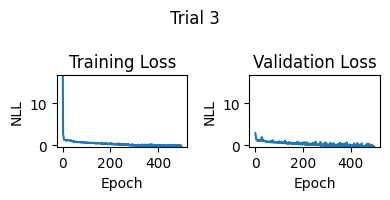

Training: 100%|██████████| 500/500 [00:13<00:00, 38.45epoch/s, Train Loss=-0.2092, Val Loss=-0.2192]


In [76]:
double_poisson_models = []
trial_to_plot = np.random.choice(num_trials)

for trial in range(num_trials):

    model, trn_losses, val_losses = train_model(DoublePoissonNN, double_poisson_nll)
    double_poisson_models.append(model)

    if trial == trial_to_plot:
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))
        fig.suptitle(f"Trial {trial}")

        axs[0].plot(trn_losses)
        axs[0].set_title("Training Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("NLL")

        axs[1].plot(val_losses)
        axs[1].set_title("Validation Loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("NLL")

        y_low = min(np.min(trn_losses), np.min(val_losses))
        y_high = max(np.max(trn_losses), np.max(val_losses))
        [ax.set_ylim(y_low, y_high) for ax in axs]

        plt.tight_layout()
        plt.show()

Evaluating Double Poisson models...:  60%|██████    | 3/5 [01:08<00:45, 22.64s/it]

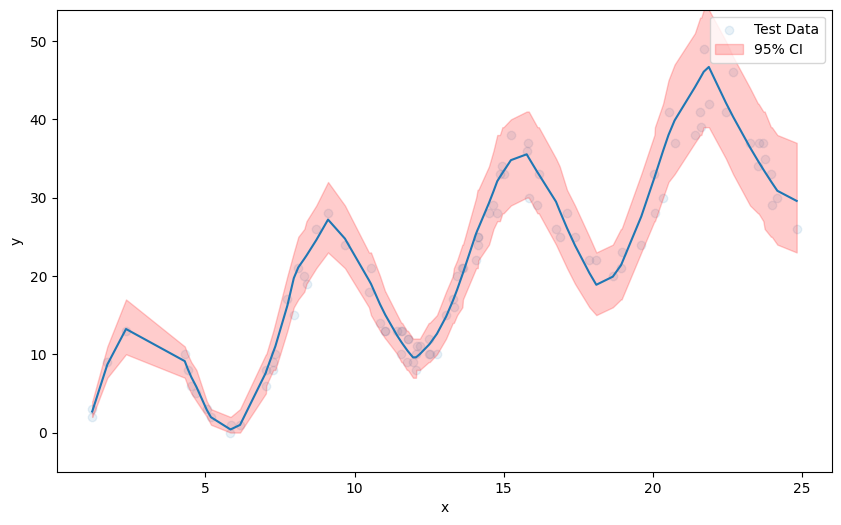

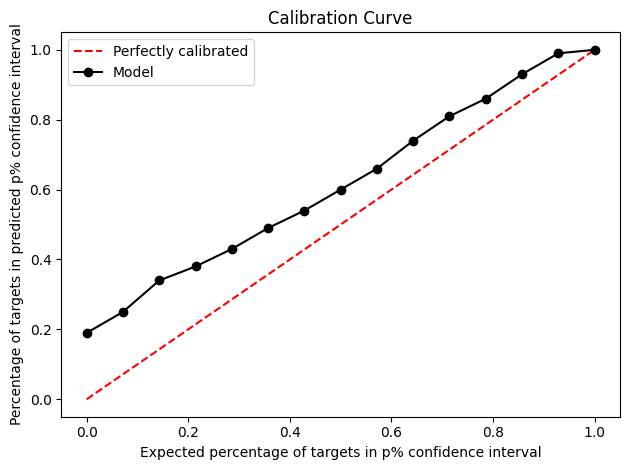

Evaluating Double Poisson models...: 100%|██████████| 5/5 [01:52<00:00, 22.57s/it]


In [77]:
double_poisson_mse = []
double_poisson_med_se = []
double_poisson_calibration_at_95 = []
double_poisson_mean_calibration = []

eval_loop = tqdm(double_poisson_models, desc="Evaluating Double Poisson models...")

for trial, model in enumerate(eval_loop):
    plot = trial == trial_to_plot
    metrics = evaluate_model(model, double_poisson_outputs_to_rv, double_poisson_rv_to_mu, plot)
    double_poisson_mse.append(metrics["mse"])
    double_poisson_med_se.append(metrics["med_se"])
    double_poisson_calibration_at_95.append(metrics["calibration@0.95"])
    double_poisson_mean_calibration.append(metrics["mean_calibration"])

## Metric Comparison

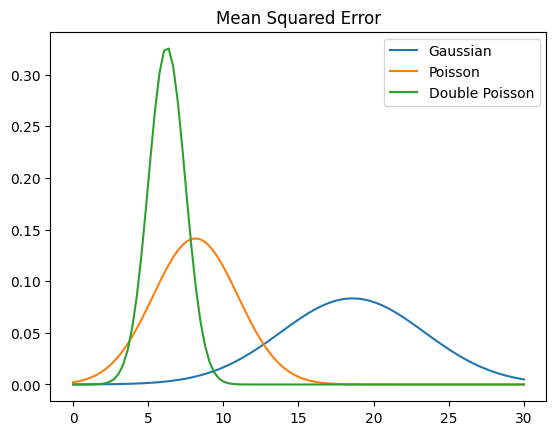

In [104]:
gaussian_mse_dist = norm(loc=np.mean(gaussian_mse), scale=np.std(gaussian_mse))
poisson_mse_dist = norm(loc=np.mean(poisson_mse), scale=np.std(poisson_mse))
double_poisson_mse_dist = norm(loc=np.mean(double_poisson_mse), scale=np.std(double_poisson_mse))
support = np.linspace(0, 30, 100)

plt.title("Mean Squared Error")
plt.plot(support, gaussian_mse_dist.pdf(support), label="Gaussian")
plt.plot(support, poisson_mse_dist.pdf(support), label="Poisson")
plt.plot(support, double_poisson_mse_dist.pdf(support), label="Double Poisson")
plt.legend()
plt.show()

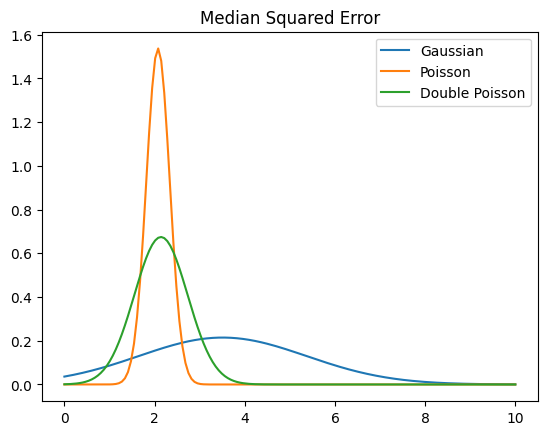

In [102]:
gaussian_med_se_dist = norm(loc=np.mean(gaussian_med_se), scale=np.std(gaussian_med_se))
poisson_med_se_dist = norm(loc=np.mean(poisson_med_se), scale=np.std(poisson_med_se))
double_poisson_med_se_dist = norm(loc=np.mean(double_poisson_med_se), scale=np.std(double_poisson_med_se))
support = np.linspace(0, 10, 150)

plt.title("Median Squared Error")
plt.plot(support, gaussian_med_se_dist.pdf(support), label="Gaussian")
plt.plot(support, poisson_med_se_dist.pdf(support), label="Poisson")
plt.plot(support, double_poisson_med_se_dist.pdf(support), label="Double Poisson")
plt.legend()
plt.show()

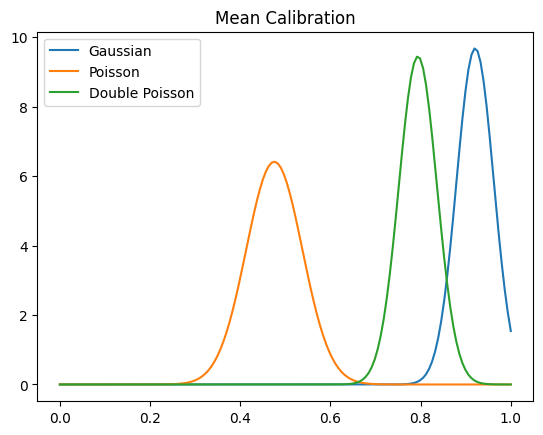

In [103]:
gaussian_mean_calibration_dist = norm(loc=np.mean(gaussian_mean_calibration), scale=np.std(gaussian_mean_calibration))
poisson_mean_calibration_dist = norm(loc=np.mean(poisson_mean_calibration), scale=np.std(poisson_mean_calibration))
double_poisson_mean_calibration_dist = norm(loc=np.mean(double_poisson_mean_calibration), scale=np.std(double_poisson_mean_calibration))
support = np.linspace(0, 1, 150)

plt.title("Mean Calibration")
plt.plot(support, gaussian_mean_calibration_dist.pdf(support), label="Gaussian")
plt.plot(support, poisson_mean_calibration_dist.pdf(support), label="Poisson")
plt.plot(support, double_poisson_mean_calibration_dist.pdf(support), label="Double Poisson")
plt.legend()
plt.show()